# **Causal Inference: understanding with an example**


# **Problem statement and hypothesis construction**
## **Problem statement**
The investigator has gathered observational data from patients who underwent Right Heart Catheterization (RHC) and from control samples. Their objective is to assess whether the RHC procedure influences patient outcomes. Additionally, they aim to investigate the influence of potential confounding variables on these outcomes.

### **Brief about Right Heart Catheterization (RHC)**

*   RHC is a diagnostic procedure where a catheter is inserted into a vein and guided into the right side of the heart to measure pressures in the right atrium, right ventricle, and pulmonary artery.
*   It is used to assess cardiac function, blood flow, and oxygen levels in conditions like heart failure, pulmonary hypertension, congenital heart defects, and shock

*   RHC provides crucial data for clinical decision-making, guiding treatment strategies, assessing response to therapy, and optimizing patient care in cardiac and critical care settings.
*   Despite its clinical utility, RHC's impact on outcomes such as mortality, length of hospital stay, and complications remains uncertain.



## **Hypothesis construction for study**

*   **Null Hypothesis (H0):** RHC procedure does not impact the patient outcome (i.e death)
*   **Alternate Hypothesis (Ha):** RHC procedure has impact on patient outcome (i.e death)





#**Lets setup the python environment and perform test**

###**Install required libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

For the todays demo we will we'll only be working with a subset of the variables in the raw dataset,feel free to experiment with more

In [ ]:
%cd /content

/content


### **Data import and cleaning**

In [ ]:
AGE = 'age'
MEANBP1 = 'meanbp1'
CAT1 = 'cat1'
SEX = 'sex'
DEATH = 'death' # outcome variable in the our raw data
SWANG1 = 'swang1' # treatment variable in our raw data
TREATMENT = 'treatment'

num_cols = [AGE, MEANBP1]
cat_cols = [CAT1, SEX, DEATH, SWANG1]

input_path = '/content/rhc.csv'
dtype = {col: 'category' for col in cat_cols}
df = pd.read_csv(input_path, usecols=num_cols + cat_cols, dtype=dtype)
print(df.shape)
df.head()

(5735, 6)


,cat1,death,age,sex,meanbp1,swang1
0,COPD,No,70.25098,Male,41.0,No RHC
1,MOSF w/Sepsis,Yes,78.17896,Female,63.0,RHC
2,MOSF w/Malignancy,No,46.09198,Female,57.0,RHC
3,ARF,Yes,75.33197,Female,55.0,No RHC
4,MOSF w/Sepsis,Yes,67.90997,Male,65.0,RHC


Lets explore the distribution of Treatment and control group i.e.


*   n_sample treatment count of patient received RHC
*   n_sample control count of patient that did not receive RHC (Control group)


In [ ]:
df[SWANG1].value_counts()

swang1
No RHC    3551
RHC       2184
Name: count, dtype: int64

Usually, in observational studies treatment group will be smaller than the control group.

Lets explore the CAT1 column which contain the information on patient condition

In [ ]:
df[CAT1].value_counts()

cat1
ARF                  2490
MOSF w/Sepsis        1227
COPD                  457
CHF                   456
Coma                  436
MOSF w/Malignancy     399
Cirrhosis             224
Lung Cancer            39
Colon Cancer            7
Name: count, dtype: int64

For the ease of the explaination and execution lets reformat the categories name in  CAT1

In [ ]:
cat1_col_mapping = {
    'ARF': 'arf',
    'MOSF w/Sepsis': 'mosf_sepsis',
    'COPD': 'copd',
    'CHF': 'chf',
    'Coma': 'coma',
    'MOSF w/Malignancy': 'mosf',
    'Cirrhosis': 'cirrhosis',
    'Lung Cancer': 'lung_cancer',
    'Colon Cancer': 'colon_cancer'
}
df[CAT1] = df[CAT1].replace(cat1_col_mapping)

Now, lets convert features' value to numerical value, and store the numerical value to the original value mapping.

In [ ]:
col_mappings = {}
for col in (DEATH, SWANG1, SEX):
    col_mapping = dict(enumerate(df[col].cat.categories))
    col_mappings[col] = col_mapping
print(col_mappings)

for col in (DEATH, SWANG1, SEX):
    df[col] = df[col].cat.codes

df = df.rename({SWANG1: TREATMENT}, axis=1)
df.head()

{'death': {0: 'No', 1: 'Yes'}, 'swang1': {0: 'No RHC', 1: 'RHC'}, 'sex': {0: 'Female', 1: 'Male'}}


,cat1,death,age,sex,meanbp1,treatment
0,copd,0,70.25098,1,41.0,0
1,mosf_sepsis,1,78.17896,0,63.0,1
2,mosf,0,46.09198,0,57.0,1
3,arf,1,75.33197,0,55.0,0
4,mosf_sepsis,1,67.90997,1,65.0,1


### **One-Hot Encoding**

One-hot encoding transforms categorical variables into a binary format where each category is represented as a binary vector (typically a vector of 0s and 1s). It creates new binary columns (one for each unique category value) and assigns a 1 or 0 to each column based on whether the original categorical variable had that particular value.

Lets apply One-hot encoding to our dataset

In [ ]:
cat_cols = [CAT1]
df_one_hot = pd.get_dummies(df[cat_cols], drop_first=True,dtype=int)
df_cleaned = pd.concat([df[num_cols], df_one_hot, df[[SEX, TREATMENT, DEATH]]], axis=1)
df_cleaned.head()

,age,meanbp1,cat1_chf,cat1_copd,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
0,70.25098,41.0,0,1,0,0,0,0,0,0,1,0,0
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
3,75.33197,55.0,0,0,0,0,0,0,0,0,0,0,1
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1


### **Check balance of Covariates across group**
This step is performed to evaluate if the coavriates are balanced among the two groups i.e. Treatment and Control.
To assess whether balance has been achieved, we can look at standardized mean differences (smd), which is calculated by the difference in the means between the two groups divided by the pooled standard deviation.


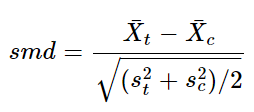
where,


*   X¯t, X¯c denotes the mean of that feature for the treatment and control group respectively. Note that people often times report the absolute value of this number.
*   s2t, s2c denotes the standard deviation of that feature for the treatment and control group respectively. For the denominator we're essentially calculating the pooled standard deviation.

**Inference based on smd value**


*   smd value <  0.1: For a randomized trial, the smd between all of the covariates should typically fall into this bucket to assume the covariates are balanced across the gorups
*   smd value 0.1 - 0.2: Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose smd fall under this range.
*   smd value > 0.2: values that are greater than this threshold are considered seriously imbalanced.







**Calculate summary statistics for the covariates**

In [ ]:
features = df_cleaned.columns.tolist()
features.remove(TREATMENT)
features.remove(DEATH)
agg_operations = {TREATMENT: 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})

table_one = df_cleaned.groupby(TREATMENT).agg(agg_operations)
table_one.head()

treatment        age               meanbp1             cat1_chf  \
              count       mean        std       mean        std      mean   
treatment                                                                   
0              3551  61.760926  17.287674  84.868629  38.874134  0.069558   
1              2184  60.749836  15.630698  68.197802  34.242209  0.095696   

                    cat1_copd           cat1_cirrhosis  ... cat1_coma  \
                std      mean       std           mean  ...      mean   
treatment                                               ...             
0          0.254436  0.112363  0.315857       0.049282  ...  0.096029   
1          0.294241  0.026557  0.160821       0.022436  ...  0.043498   

                    cat1_lung_cancer           cat1_mosf            \
                std             mean       std      mean       std   
treatment                                                            
0          0.294673         0.009575  0.097395  0.067868  0.251555   
1          0.204022         0.002289  0.047804  0.072344  0.259117   

          cat1_mosf_sepsis                 sex            
                      mean       std      mean       std  
treatment                                                 
0                 0.148409  0.355555  0.539003  0.498547  
1                 0.320513  0.466781  0.585165  0.492806  

[2 rows x 23 columns]

###**SMD calculation**

In [ ]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})


table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,age,0.0614
1,meanbp1,0.4551
2,cat1_chf,0.0950
3,cat1_copd,0.3424
4,cat1_cirrhosis,0.1447
5,cat1_colon_cancer,0.0376
6,cat1_coma,0.2073
7,cat1_lung_cancer,0.0950
8,cat1_mosf,0.0175
9,cat1_mosf_sepsis,0.4148


**Inference based on smd values**

Based on above table:

* covariates namely  Age, cat1_chf,cat1_cirrhosis, cat1_colon_cancer, cat1_coma,cat1_lung_cancer,cat1_mosf and sex are observed to be balanced acorss groups    
*   Whareas covariated namely meanbp1, cat1_copd, and cat1_mosf_sepsis are observed to be imbalanced across the groups

Potential reasons for covariate imbalance:

*   When covariates are rare (outliers) or have extreme values (leverage points), it can be challenging to find appropriate matches or weights, leading to imbalance.
*   Factors that are associated with both treatment assignment and outcomes but are not measured or included in the analysis can lead to imbalance in observed covariates.
*   If relationships between covariates and treatment assignment or outcomes are non-linear, simple matching or weighting methods may not adequately balance covariate distributions between groups.
*   In studies with small sample sizes, random variation can lead to non-optimal balance between treatment groups, resulting in higher SMD values.

**How to handle covariates with SMD values greater than 0.2**



**1.   Re-evaluate Covariates:** verify if these covariates are essential for controlling confounding. Sometimes, less important covariates with high SMD values may be omitted or less aggressively balanced.

**2.Consider propensity score Model Adjustment:**

*   Adding higher-order terms (e.g., quadratic terms) for continuous covariates
*   Adding interactions or non-linear terms if appropriate.
*   Considering transformations (e.g., logarithmic transformation) if the distribution of covariates is skewed.

**3. Matching Strategies:**

Explore different matching techniques.
*   Exact matching or caliper matching might help improve balance on critical covariates.
*   Use nearest neighbor matching with a smaller caliper to ensure closer matches on key covariates.

In the present demo we will continue with all the covariates as is

###**Estimation of propensity score**

In present example treatment is our label for estimating the propensity score, and death is the outcome that we care about, thus is also removed from the step that is estimating the propensity score

In [ ]:
death = df_cleaned[DEATH]
treatment = df_cleaned[TREATMENT]
df_cleaned = df_cleaned.drop([DEATH, TREATMENT], axis=1)

column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), num_cols)],
    sparse_threshold=0,
    remainder='passthrough'
)
data = column_transformer.fit_transform(df_cleaned)
data.shape


(5735, 11)

Since our label valiable is binary we will use logistic regression to estimate the propensity score

In [ ]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(data, treatment)

LogisticRegression(solver='liblinear')

In [ ]:
pscore = logistic.predict_proba(data)[:, 1]
pscore

array([0.20154127, 0.5509091 , 0.40984634, ..., 0.17665098, 0.18749952,
       0.22041189])

In [ ]:
roc_auc_score(treatment, pscore)

0.6903390599356525

The Roc_auc_score of 0.69 indicate the model fit is fair to use for further understanding

After estimating the propensity score, it's advised to check for overlap before proceeding directly to the matching process. This involves comparing the distribution of propensity scores between subjects in the control and treatment groups.

In [ ]:
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (2184,)
control count: (3551,)


**Propensity distribution plot**

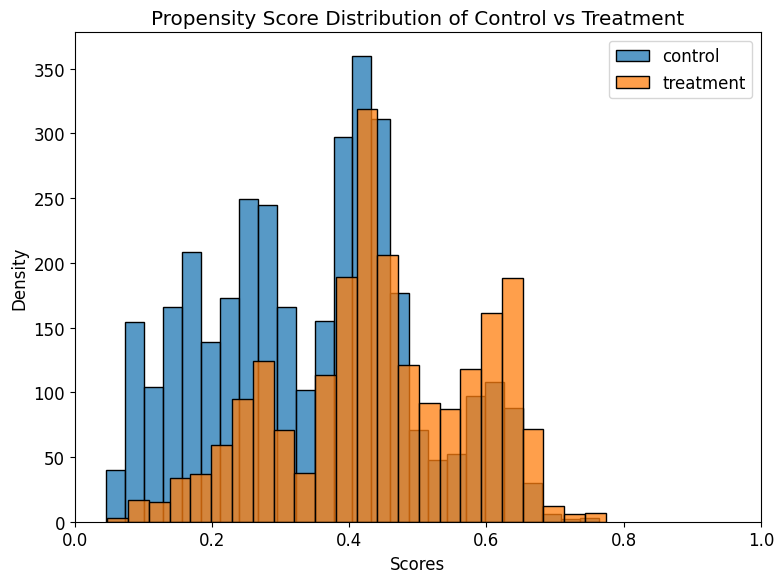

In [ ]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.histplot(neg_pscore, label='control')
sns.histplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

**Interpretation**


*   Looking at the plot below, we can see that our features,  X
 , does in fact contain information about the user receiving treatment.

*   The distributional difference between the propensity scores for the two group justifies the need for matching, since they are not directly comparable otherwise
*   The overlapping histogram indicate there is signifcant overlapping for propensity score across group that indicate propensity score matching

The next step is to perform matching. In general, the procedure looks like this:

1.   compute the distance between the estimated propensity score for each treated subject with every control.
2.   for every treated subject we would find the subject in the control that has the closest distance to it.
3.   Finally, these pairs are "matched" together and will be included in the final dataset that will be used to estimate the causal effect.


Here, what we'll do is: for every record in the treatment we find its closest record in the control group without controlling for distance threshold and duplicates

In [ ]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[1703],
       [1329],
       [2782],
       ...,
       [1728],
       [1909],
       [2546]])

After applying the matching procedure, it's important to check and validate that the matched dataset are indeed indistinguishable in terms of the covariates that we were using to balance the control and treatment group.

In [ ]:
df_cleaned[TREATMENT] = treatment
df_cleaned[DEATH] = death
df_pos = df_cleaned[mask]
df_neg = df_cleaned[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,age,meanbp1,cat1_chf,cat1_copd,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1
9,48.42398,73.0,0,0,0,0,0,0,0,0,0,1,0
11,68.34796,50.0,0,0,0,0,0,0,0,0,1,1,0


In [ ]:
table_one_matched = df_matched.groupby(TREATMENT).agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched)
table_one_smd_matched

,features,smd
0,age,0.0160
1,meanbp1,0.0072
2,cat1_chf,0.0184
3,cat1_copd,0.0557
4,cat1_cirrhosis,0.0091
5,cat1_colon_cancer,0.0707
6,cat1_coma,0.0091
7,cat1_lung_cancer,0.0626
8,cat1_mosf,0.0035
9,cat1_mosf_sepsis,0.0039


**Interpretation of smd table after propensity score matching**



*   Upon completing propensity score matching and verified that our covariates are now fairly balanced using standardized mean difference (smd), we can carry out a outcome analysis using a paired t-test.
*   For all the various knobs that we've described when introducing the matching process, we can experiment with various options and see if our conclusions change.

###**Paired t-test**

In [ ]:
num_matched_pairs = df_neg.shape[0]
print('number of matched pairs: ', num_matched_pairs)

# pair t-test
stats.ttest_rel(df_pos[DEATH].values, df_neg[DEATH].values)

number of matched pairs:  2184


TtestResult(statistic=2.98993204105555, pvalue=0.0028215776367738962, df=2183)

**Inference of paired t test**


*   P value is statistically significant (i.e. p-value < 0.05) indicate the rejection of null hypothesis
*   Rejection of null hypothesis infers that receiving Right Heart Catheterization does have an effect on a patient's chance of dying.

